# Testing Models & Random Sampling Methods for MultiClass Classification;

## I couldn't find a therapist so I tried to build one

 Project by Kevin Chung


## Importing all dependencies

In [1]:
'''''''''''''''''''''''''''''''''
*      Text Pre-Processing      *
'''''''''''''''''''''''''''''''''
import pandas as pd
import nltk
import re
import numpy as np
import umap.umap_ as umap
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler


'''''''''''''''''''''''''''
*        Plotting         *
'''''''''''''''''''''''''''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import umap.plot
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud, ImageColorGenerator


'''''''''''''''''''''''''''''''''
*      Training & Metrics      *
'''''''''''''''''''''''''''''''''
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from scipy import interp
from itertools import cycle
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


'''''''''''''''''''''''''''
*     Model Selection     *
'''''''''''''''''''''''''''
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

## Importing Dataset and Creating Holdout Data

I set the holdout dataset to contain 5 documents from each class for testing purposes at the end.

In [2]:
'''import'''
df = pd.read_csv('master_f.csv')
df.fillna(method = 'pad')


'''assigning labels and storing in variable to prepare for holdout creation'''
df_dep = df.loc[df['label'] == 0] 
df_ptsd = df.loc[df['label'] == 1]
df_cptsd = df.loc[df['label'] == 2] 
df_bpd = df.loc[df['label'] == 3]
df_bipolar = df.loc[df['label'] == 4] 
df_diss = df.loc[df['label'] == 5]


'''creating holdouts'''
df_dep_holdout = df_dep.iloc[:5]
df_ptsd_holdout = df_ptsd.iloc[:5]
df_cptsd_holdout = df_cptsd.iloc[:5]
df_bpd_holdout = df_bpd.iloc[:5]
df_bipolar_holdout = df_bipolar.iloc[:5]
df_diss_holdout = df_diss.iloc[:5]


'''re-defining variables with holdout documents ommitted'''
df_dep = df_dep.iloc[5:]
df_ptsd = df_ptsd.iloc[5:]
df_cptsd = df_cptsd.iloc[5:]
df_bpd = df_bpd.iloc[5:]
df_bipolar = df_bipolar.iloc[5:]
df_diss = df_diss.iloc[5:]


'''concat the pieces back together'''
df = pd.concat([df_dep, df_ptsd, df_cptsd, df_bpd, df_bipolar, df_diss])
df_holdout = pd.concat([df_dep_holdout, df_ptsd_holdout, df_cptsd_holdout, df_bpd_holdout, df_bipolar_holdout, df_diss_holdout])
df.dropna()

print(df.shape)
print(df.keys())

(10091, 2)
Index(['label', 'text'], dtype='object')


## Text Pre-Processing

Process:
- Remove special characters
- Remove stopwords
- Word lemmatization
- Tokenization
- Vectorization
- Dimensionality reduction

In [13]:
'''
# defining symbols/characters to remove
# set the stopword to 'english'
# define tokenizer & lemmatizer
'''
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;']")
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()




'''defining method for cleaning text input'''
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(x for x in text.split() if x not in STOPWORDS) # delete stopwors from text
    return text


'''defining lemmatizer'''
def word_lemmatizer(text):
    lem_text = [LEMMATIZER.lemmatize(x) for x in text]
    return lem_text  


'''applying pre-processing'''
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(lambda x: TOKENIZER.tokenize(x))
df['text'] = df['text'].apply(lambda x: word_lemmatizer(x))


df = df.dropna(how='any',axis=0)
df.shape

(10091, 2)

# TW / CW
This portion may contain triggering statements. Proceed at your own discretion

## Corpus Exploration

Process:
- Frequency distribution of most common words, excluding redundant and unmeaningful words.
- Finding concordances for a word of interest (I select the word, 'want')
- Finding quadgram collocations for the most common words in the corpus

In [14]:
'''defining the corpus from cleaned text'''
corpus = []


'''creating exclusion list & updating corpus'''
for document in df['text']:
    exclude_list = ['anyone', 'else', 'feel', 'like', "dont", 'know', "im", 'new', '[]', 'ive', 'really', 'would']
    for text in document:
        if text not in exclude_list:
            corpus.append(text)


'''Frequency distribution'''
fd = nltk.FreqDist(corpus)
print(fd.most_common(20))

[('time', 7585), ('get', 7045), ('want', 6204), ('thing', 6111), ('year', 5957), ('people', 5670), ('life', 5577), ('one', 5162), ('day', 4934), ('even', 4883), ('think', 4727), ('go', 4406), ('feeling', 4095), ('much', 3952), ('help', 3760), ('going', 3756), ('make', 3709), ('back', 3569), ('never', 3558), ('thought', 3503)]


In [15]:
'''printing a list of concordances for the word, "want" '''
text = nltk.Text(corpus)
concordance_list = text.concordance_list("want", lines=20)
for entry in concordance_list:
    print(entry.line)
    
    
'''finding collocations for most common words'''
finder = nltk.collocations.QuadgramCollocationFinder.from_words(text)
finder_list = finder.ngram_fd.most_common(20)
for find in finder_list:
    print(find)

l think ruined honor locking 3 month want go back work living house live diffe
 bad afraid tired everyday nightmare want lose life person fell love please he
idal teen week struggling experience want come home need stay longer get medic
ng promoted afford monthly rent plus want emergency saving fund live mother cl
r anybody relate advice thanks hi dr want sign two week go ahead go work dr gi
let stress let honest get lot stress want come home hurt see depression suicid
get peaceful dreamy 3 hour ever rare want want wake much better time asleep sa
eaceful dreamy 3 hour ever rare want want wake much better time asleep sad dep
t face name others similar situation want tell last spend sunny day loved one 
fear losing mom shes one trust world want die hopeless starting get anger issu
onfident sexy hate negative attitude want stop therapy support group gonna get
forcing pretend happy positive didnt want throw hand say amazing instead looke
ad looked got mad said uncomfortable want talk immat

# Feature Exploration

Process:
- Vectorization
- Generate WordCloud for better visualization
- Obtain bar graph of the 50 most common features
- Dimensionality reduction for transforming sparse data & visualization of features
- Visualizing class distribution & balancing out samples in each class (2 methods are compared)
    - RandomOverSampling
    - RandomUnderSampling

## Vectorization

In [32]:
'''defining vectorizer'''
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.5, 
                             smooth_idf=True)


'''vectorizing text, and mapping the labels'''
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}

X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)


print(X.shape)
y.shape

(10091, 24176)


(10091,)

## WordCloud Generation

This WordCloud was a challenge due to the .get_feature_names() method returning duplicate words with an apostrophy at the end. I specified the redundancies to exclude by studying the WordCloud, and the results look much cleaner and more insightful than before. The result is also consistent with the frequency distribution I did on the corpus earlier.

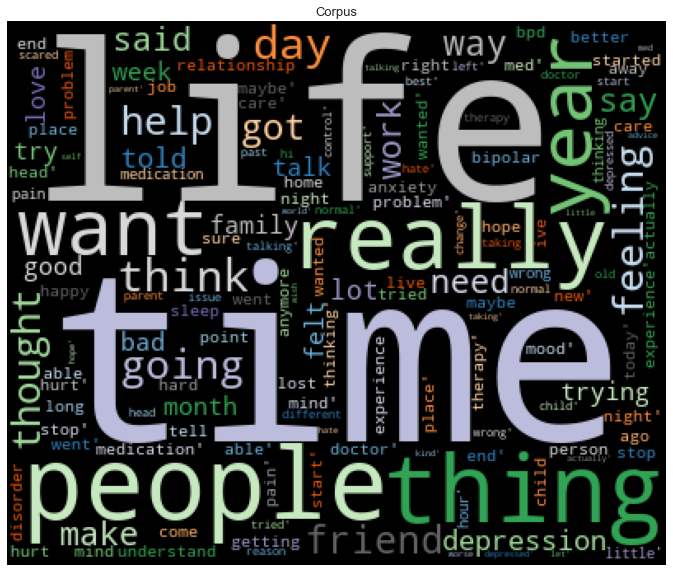

In [41]:
'''exclusion list of redundant features (predominantly duplicate words with an apostrophy)'''
exclude_list = ['anyone', 'else', 'feel', "feel'", 'like',"like'", 
                "dont", "dont'", 'know', "im'","im", 'new', "time'", 
                "people'", "year'", "life'","ive'", "know'", "think'", 
                "day'", "thing'", "really'", "friend'", "want'", "said'",
                "make'", "thought'", "told'", "help'", "going'", "dindt'", 
                "felt'", "good'", "didnt'", "depression'", "way'", "got'", 
                "week'", "month'", "say'", "try'", "work'", "feeling'", "lot'",
                "relationship'", "talk'", "family'", "tell'", "anxiety'", "need'", "long'",
                "bad'", "love'", "self'", "away'", "better'", "right'", "doesnt'", "right'", "point'", "come'",
                "job'", "issue'", "getting'", "hard'", "mental'", "bipolar'", "started'", "person'",
                "home'", "wwanted'", "bpd'", "happy'", "leave'", "past'", "live'", 
                "trying'", "house'", "understand'", "anymore'", "feel abit", "sleep'"]


'''getting the names of features and storing them into a new list with the exclusion in place'''
features = vectorizer.get_feature_names()
features_list = []
for feature in features:
    if feature not in exclude_list:
        features_list.append(feature)

        
'''defining method to generate a WordCloud'''
def generate_wordcloud(data, title):
    cloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=exclude_list,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(14,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.show()
    
generate_wordcloud(str(features_list), 'Corpus')

In [34]:
'''checking for null values'''
pd.isnull(df).sum() > 0

label    False
text     False
dtype: bool

## Visualizing Top 50 Features

Note that some features are bigrams, as specified in the vectorizer under the n_gram_range parameter.

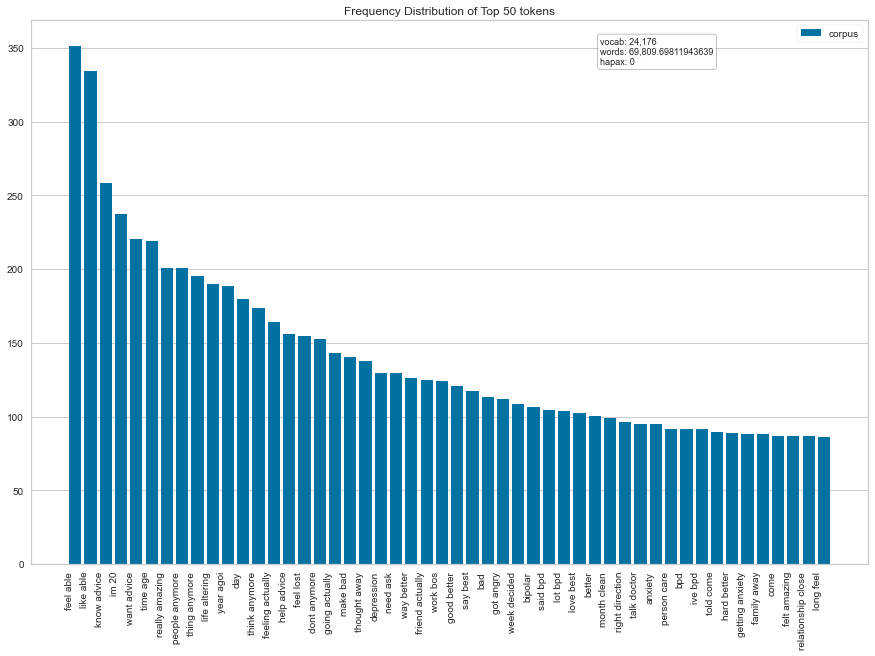

<Figure size 576x396 with 0 Axes>

In [42]:
'''Yellowbrick helps visualize features really easily!'''
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features_list, orient='v', size=(1080,720))
visualizer.fit(X)
visualizer.show()
plt.savefig('top_50.png', dpi=500)

## Dimensionality Reduction with UMAP

The plot below shows that I was able to reduce the dimensions of the dataset and achieved decent separation of the classes. Note that this has been reduced down to 2-dimensions, and would likely achieve a more robust figure when expanded slightly. Let's take a closer look.

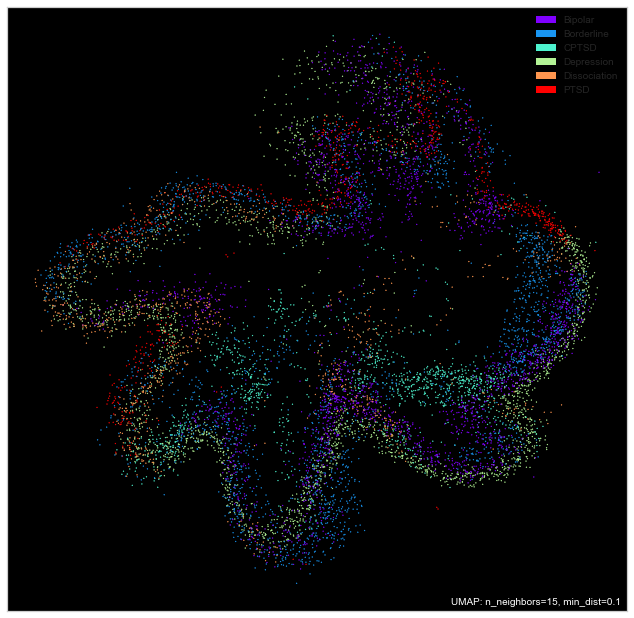

In [43]:
'''default for UMAP is 2-dimensions, at 15 neighborhoods and 0.1 min_dist.'''
mapper = umap.UMAP().fit(X)

%matplotlib inline
umap.plot.points(mapper, labels=y_label, theme='fire')
plt.savefig('dimension_reduced.png', dpi=500)

## Feature Exploration Tool with BokehJS 

By hovering over this plot below, Bokeh allows us to take a much more intimate look at the features. By mapping the appropriate labels we can easily visualize where in the matrix the classes are clustered. 

In [44]:
hover_data = pd.DataFrame({'index': np.arange(len(y)),
                           'label': y})
hover_data['item'] = hover_data.label.map({0:'depression',
                                           1:'ptsd',
                                           2:'cptsd',
                                           3:'bpd',
                                           4:'bipolar',
                                           5:'dissociation'})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=y, hover_data=hover_data, point_size=2)
umap.plot.show(p)

Loading BokehJS ...

## Feature Relationships (edge-bundling) Visualization

These adjacent relationships of embeddings show distinct branches with relatively clean bundling. This shows that the embedding achieves a decent spread over the matrix, and will likely yield good results. 

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\umap\plot.py:855: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


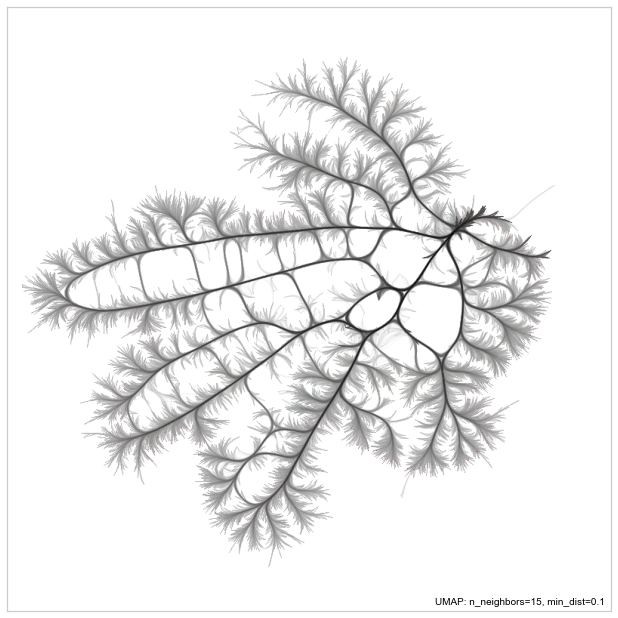

In [46]:
%matplotlib inline
umap.plot.connectivity(
    mapper, 
    edge_bundling="hammer",
    cmap="rainbow",
    labels=y,
    show_points=True
)
plt.savefig('comorbidity.png', dpi=500)

## Class Distribution Visualization

However, when taken a closer look, we see a very imbalanced distribution of classes. This is due to the lack of availability of documents for certain labels, while others had plenty. Normalization of these classes is the next appropriate step.

Text(0.5, 1.0, 'Classes Distribution')

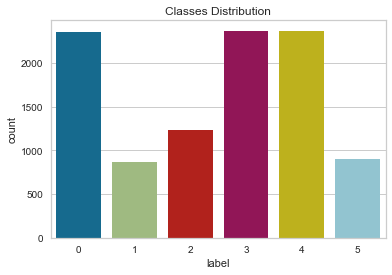

In [58]:
sns.countplot(x='label', data=df)
plt.title("Classes Distribution")

## Balancing Out Class Distribution (2 methods)

From this point on, I compare the performance of two different methods of random sampling - starting with Random Over Sampler, then Random Under Sampler.

In [59]:
'''Random Over Sampling is a method that evens out the distribution of your classes by inflating the underrepresented classes.'''
ovs = RandomOverSampler(random_state=42)
X_res, y_res = ovs.fit_resample(X,y)


'''Random Under Sampling is the converse of ROS, where the overrepresented classes are reduced to match the underrepresented classes'''
ous = RandomUnderSampler(random_state=42)
X_res_b, y_res_b = ous.fit_resample(X,y)

In [60]:
print("original class counts: " + str(pd.value_counts(y.ravel())))
print("new class counts: " + str(pd.value_counts(y_res.ravel())))
print("new class counts: " + str(pd.value_counts(y_res_b.ravel())))

original class counts: 4    2370
3    2364
0    2361
2    1228
5     906
1     862
dtype: int64
new class counts: 0    2370
1    2370
2    2370
3    2370
4    2370
5    2370
dtype: int64
new class counts: 0    862
4    862
1    862
5    862
2    862
3    862
dtype: int64


## PCA Diagnostics of Redistributed Classes

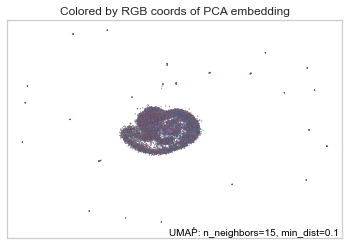

In [61]:
mapper_a = umap.UMAP().fit(X_res)

%matplotlib inline

umap.plot.diagnostic(mapper_a, diagnostic_type='pca')
plt.savefig('PCA Diagnostic X_res.png', dpi=500)

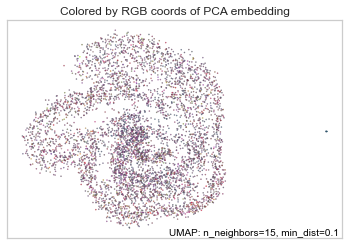

In [62]:
mapper_b = umap.UMAP().fit(X_res_b)

%matplotlib inline

umap.plot.diagnostic(mapper_b, diagnostic_type='pca')
plt.savefig('PCA Diagnostic X_res_b.png', dpi=500)

# Testing ROS with Several Models for Comparison

## Random Over Sampling - put to the test

I specified several neighborhoods to compare performance. I raised the dimensionality to 6 because the number of unique classes I am examining is 6. Hopefully I retain more information this way and achieve better separation in the classes.

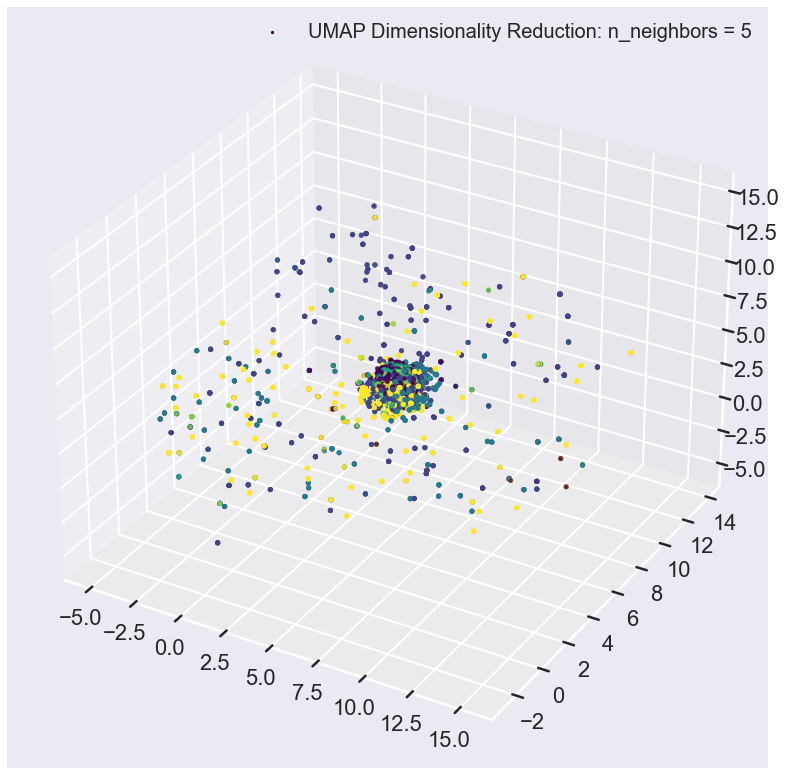

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.630567        0.631972     0.629028   
6           K Nearest Neighbor       0.556728        0.556125     0.555315   
3               Decsision Tree       0.532114        0.533519     0.530477   
4                     AdaBoost       0.366151        0.367621     0.366171   
5         Gaussian Naive Bayes       0.261838        0.314094     0.262833   
7          Logistic Regression       0.246367        0.223396     0.245459   
1  Stochastic Gradient Descent       0.184482        0.200844     0.181803   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.629674  
6  0.554084  
3  0.531655  
4  0.363844  
5  0.230837  
7  0.226502  
1  0.094287  
0  0.046698  


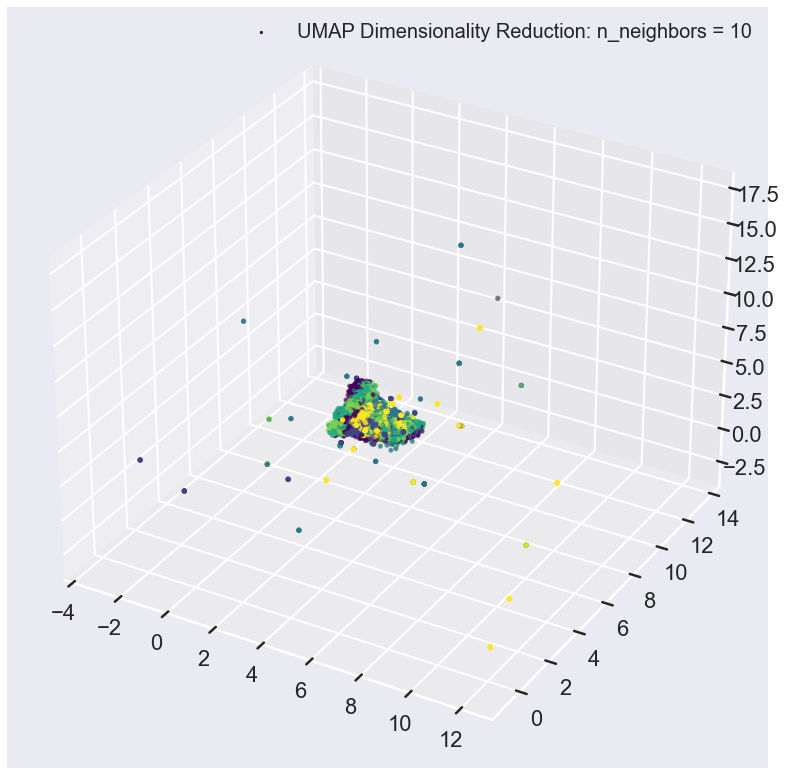

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.760197        0.759917     0.759932   
6           K Nearest Neighbor       0.756446        0.756855     0.756405   
3               Decsision Tree       0.654946        0.656542     0.654771   
4                     AdaBoost        0.48617        0.480267     0.485466   
7          Logistic Regression       0.362635        0.338729     0.361204   
5         Gaussian Naive Bayes         0.2609        0.229806     0.259633   
1  Stochastic Gradient Descent       0.190811         0.26616     0.191432   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.759624  
6  0.755592  
3  0.655427  
4  0.475282  
7  0.338073  
5  0.209489  
1  0.094583  
0  0.046698  


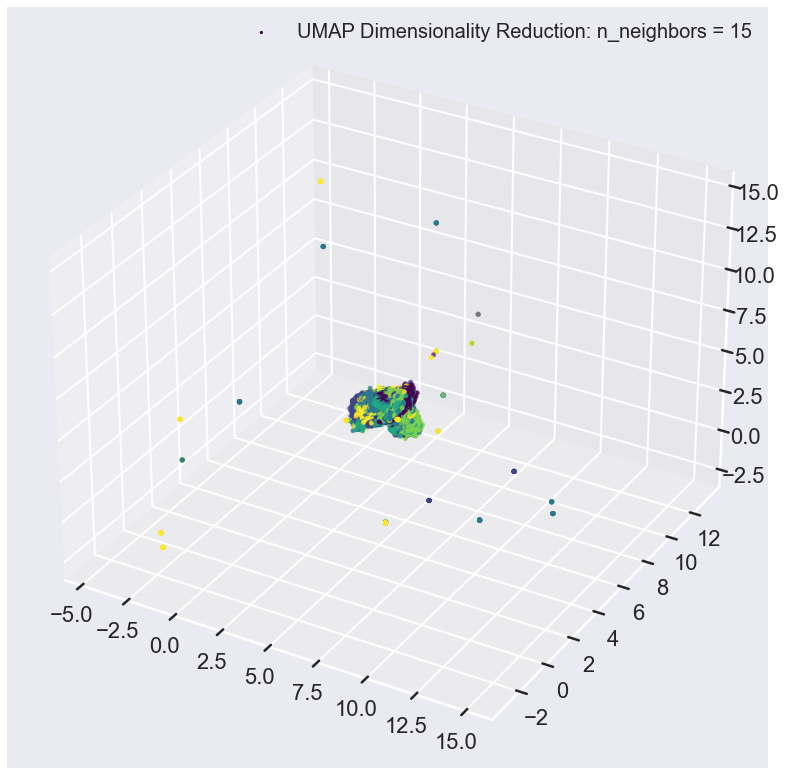

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.830286         0.83052     0.830276   
2                Random Forest       0.823488        0.823161     0.823182   
3               Decsision Tree       0.725973        0.726673     0.726122   
4                     AdaBoost        0.46601        0.465649     0.465847   
7          Logistic Regression       0.231833        0.210928      0.23102   
5         Gaussian Naive Bayes       0.228786        0.190059      0.22816   
1  Stochastic Gradient Descent       0.172293        0.101177     0.175908   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
6   0.83016  
2  0.822982  
3  0.726196  
4  0.454188  
7  0.210354  
5  0.178412  
1   0.06431  
0  0.046698  


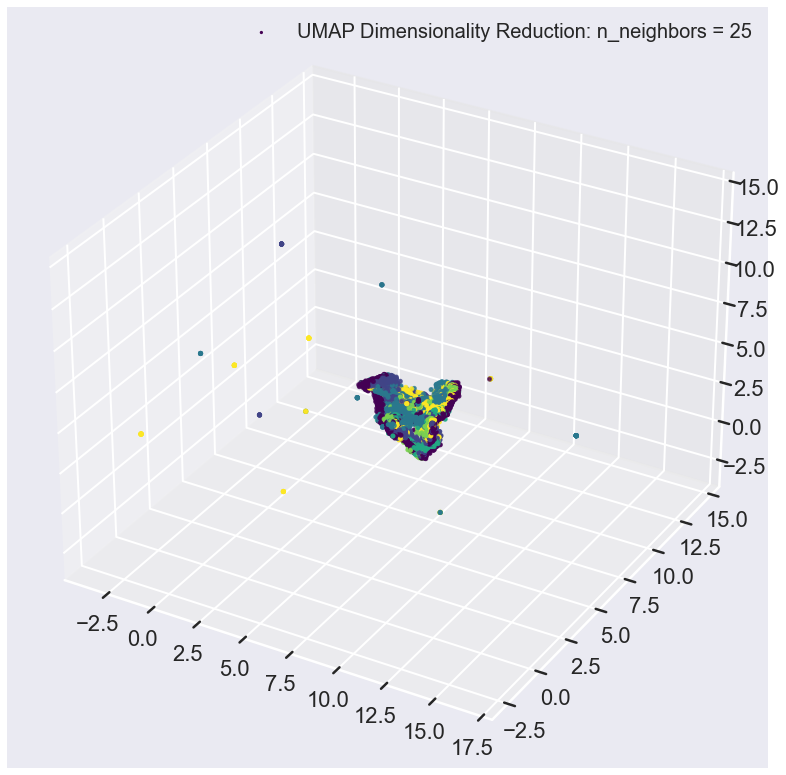

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.861463        0.861889      0.86151   
2                Random Forest       0.856774        0.856646     0.856656   
3               Decsision Tree       0.758322         0.75813     0.758323   
4                     AdaBoost       0.437647        0.430615     0.438735   
7          Logistic Regression       0.272621        0.259661      0.27233   
5         Gaussian Naive Bayes       0.273558        0.303458     0.274249   
1  Stochastic Gradient Descent       0.166432        0.194353     0.167588   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
6  0.861151  
2  0.856453  
3  0.758178  
4  0.431347  
7   0.25237  
5  0.207035  
1  0.049315  
0  0.046698  


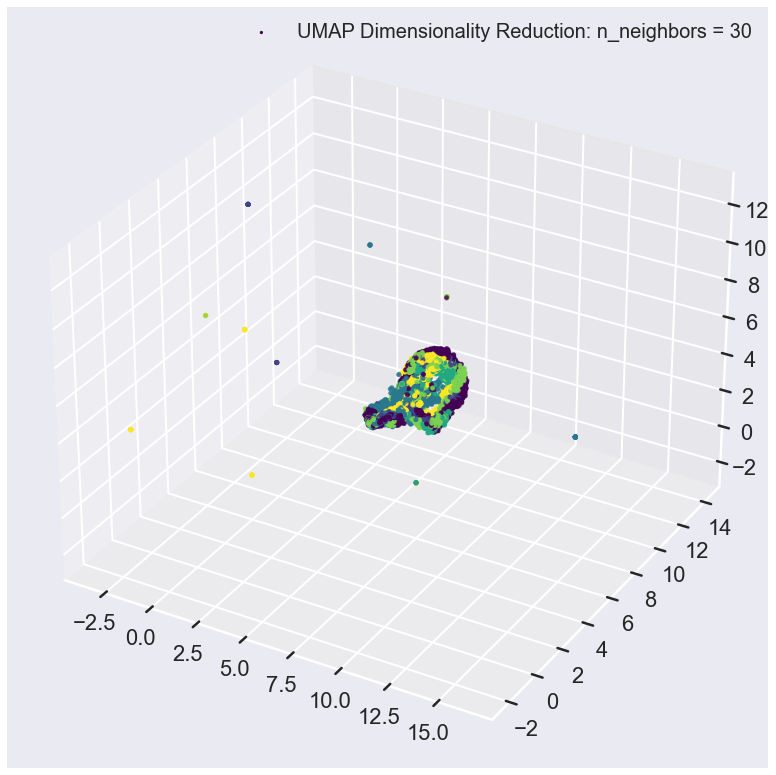

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.899203        0.899372     0.899103   
6           K Nearest Neighbor       0.897562        0.898423     0.897535   
3               Decsision Tree        0.81458        0.815275     0.814418   
4                     AdaBoost       0.433427        0.428739      0.43335   
5         Gaussian Naive Bayes       0.311533        0.297607     0.311642   
7          Logistic Regression       0.261838        0.237044     0.261726   
1  Stochastic Gradient Descent       0.163619        0.148107     0.167349   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
2  0.899122  
6  0.897507  
3  0.814657  
4  0.422044  
5  0.249427  
7  0.232324  
1  0.048696  
0  0.046698  


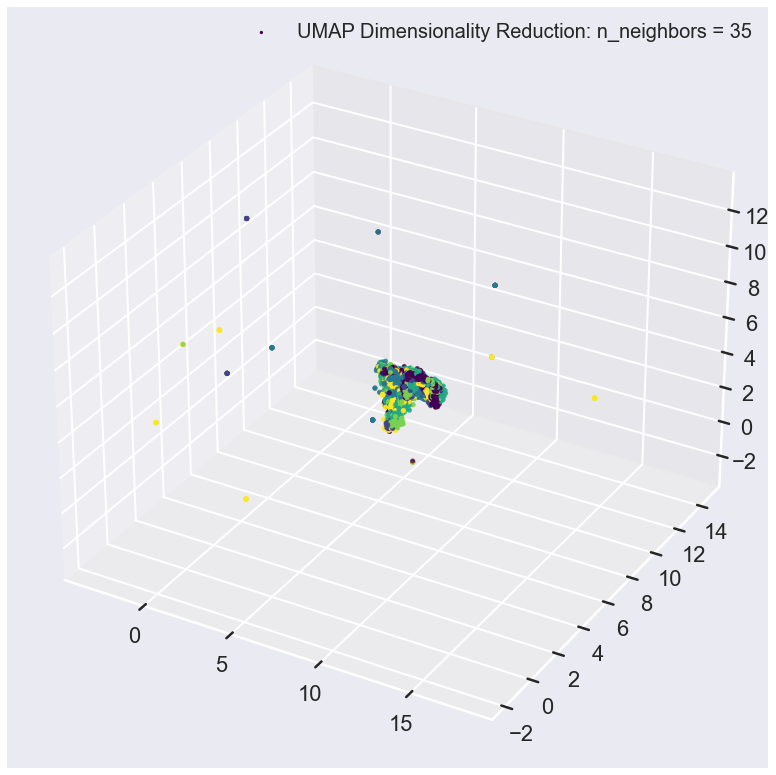

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.918425        0.918264     0.918365   
2                Random Forest       0.913268        0.913163     0.913227   
3               Decsision Tree       0.838256         0.83841     0.838258   
4                     AdaBoost        0.37248        0.360521     0.372061   
5         Gaussian Naive Bayes       0.274027        0.288751     0.274998   
7          Logistic Regression       0.229255        0.200526     0.229604   
1  Stochastic Gradient Descent       0.172293        0.132685      0.17351   
0                        Dummy       0.162916        0.027153     0.166667   

   f1_score  
6  0.918164  
2  0.913115  
3  0.838283  
4  0.361004  
5  0.227843  
7  0.191051  
1  0.074797  
0  0.046698  


In [64]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 6,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

## Results

I achieved the optimal result at n_neighbors = 35. I reset the data_umap variable below for further analysis.

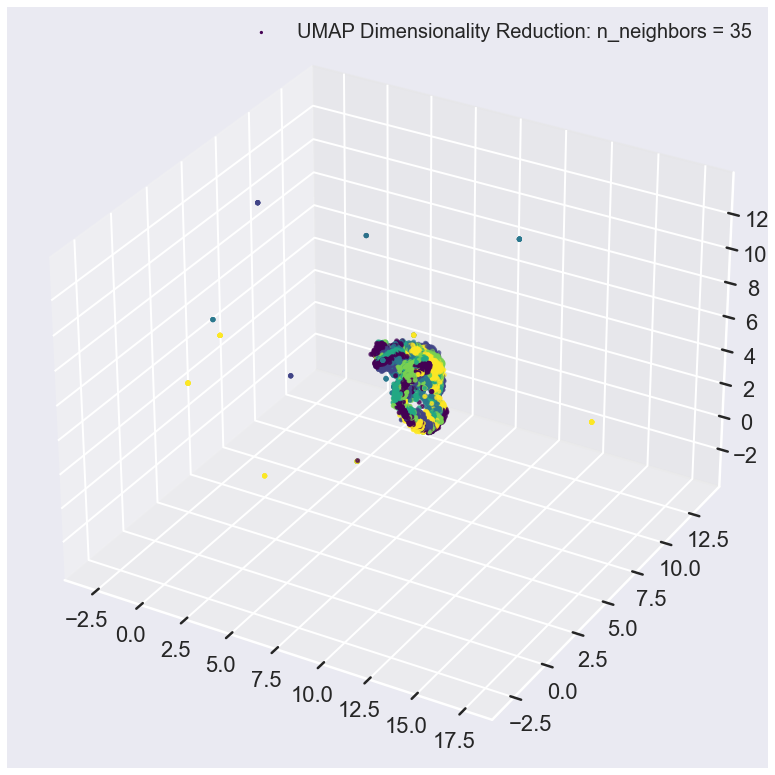

model_name accuracy_score precision_score recall_score  f1_score
3  K Nearest Neighbor       0.909517        0.909733     0.909236   0.90905
0       Random Forest       0.896859        0.896315     0.896429  0.896299
1      Decsision Tree       0.817628        0.816996     0.817167  0.817015
2            AdaBoost       0.435302        0.423484     0.435051  0.424346

In [65]:
fit = umap.UMAP(n_neighbors = 35,
                min_dist = .1,
                n_components = 6,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 35'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                    y_res, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



# KNN GridSearchCV - looking for the best parameters 

A cautionary tale, this takes a huge burden on the CPU, 

In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res, y_res)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [174]:
KNN_best = gridsearch.best_params_
print(KNN_best)

{'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


In [66]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=7,
                                      p =2,
                                      weights='distance')

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


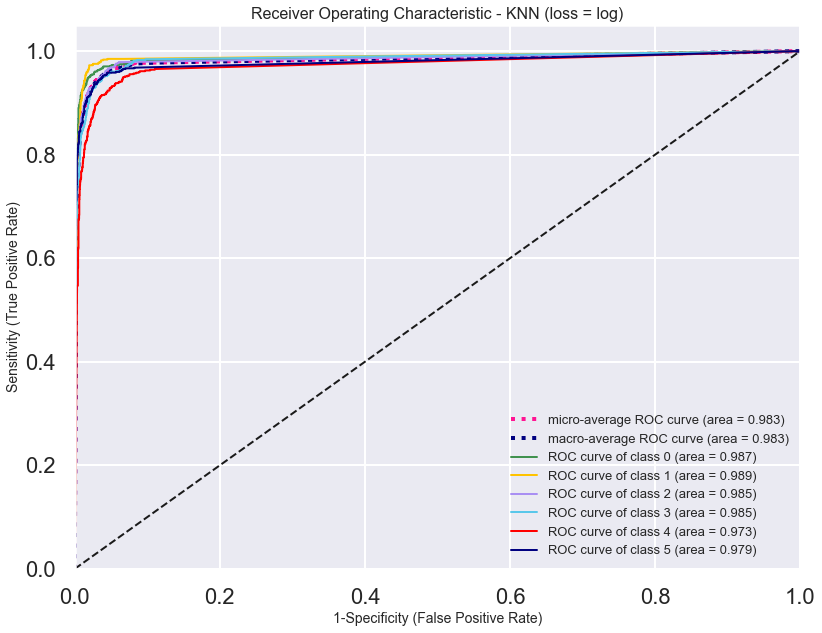

In [67]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

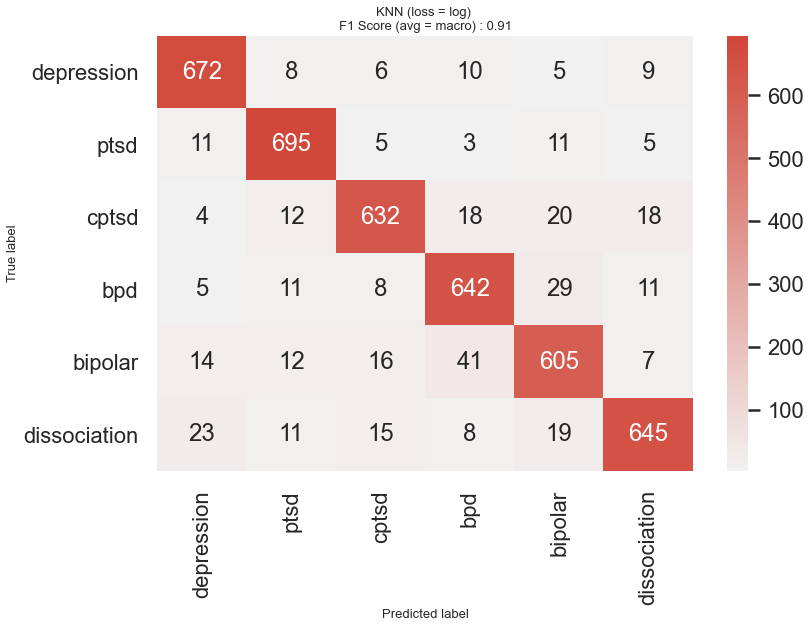

In [68]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_c, y_train_c)
y_pred = knn_best_model.predict(X_test_c)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_c, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_c, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


In [69]:

unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(data_umap,y_res)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


0.13333333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.15      0.80      0.25         5

    accuracy                           0.13        30
   macro avg       0.02      0.13      0.04        30
weighted avg       0.02      0.13      0.04        30



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text  label  pred_knn  \
0     I feel this way most days and I'm getting sick...      0         5   
1            Saw this today and wanted to share it. 💕 💕      0         5   
2     I can understand if my situation was a permane...      0         5   
3     So suicidal thoughts are really common to me b...      0         5   
4     If any wants to share their experience.\n\nI r...      0         5   
2366  Dave Carbonell, Ph.D, Psychologist, the author...      1         5   
2367  Hi guys,\nI have been diagnosted with a trauma...      1         5   
2368  Sooo, in November 2019, around Thanksgiving, i...      1         5   
2369  My absence record at work is fine. I’ve only h...      1         5   
2370  I was diagnosed with PTSD back in December.\n\...      1         5   
3233  Hi guys! Do anyone stay on high alert so much,...      2         5   
3234  29 year old male.  I have never been diagnosed...      2         5   
3235  Hi, does anyone here have any physical effects...      2         5   
3236  I've been going through a shit ton of trauma l...      2         5   
3237  Hey y'all. I have c-PTSD and a never ending am...      2         5   
4466  Hi, I would really appreciate if anyone could ...      3         5   
4467  Hello, I’ve been googling a lot on this subjec...      3         5   
4468  i had to leave my home and am staying with my ...      3         5   
4469  Hi all I've been recently diagnosed with eupd ...      3         5   
4470  I’ve been feeling so lonely & I don’t have any...      3         5   
6835  Cyclothymia :: Mental Health Issues :: Signpos...      4         1   
6836  Comprehensive information /  FAQ'S about bipol...      4         5   
6837  Hi all I've been recently diagnosed with eupd ...      4         1   
6838  ever feel like you're part of a production?\nb...      4         5   
6839  I find I am looking for the pat on the back ty...      4         5   
9210  I was talking to a coworker an amidst the conv...      5         5   
9211  Hello, I have recently started questioning if ...      5         5   
9212  Hi you lovelies reading. <3 I hope dearly this...      5         5   
9213  Hi,\n\nI'm new here and had multiple dissociat...      5         5   
9214  Sort of the opposite of feeling as if I am not...      5         1   

      correct  
0           0  
1           0  
2           0  
3           0  
4           0  
2366        1  
2367        1  
2368        1  
2369        1  
2370        1  
3233        2  
3234        2  
3235        2  
3236        2  
3237        2  
4466        3  
4467        3  
4468        3  
4469        3  
4470        3  
6835        4  
6836        4  
6837        4  
6838        4  
6839        4  
9210        5  
9211        5  
9212        5  
9213        5  
9214        5

# Testing out Random Under Sampling

Finally, we get to review the models' performance provided a RUS.

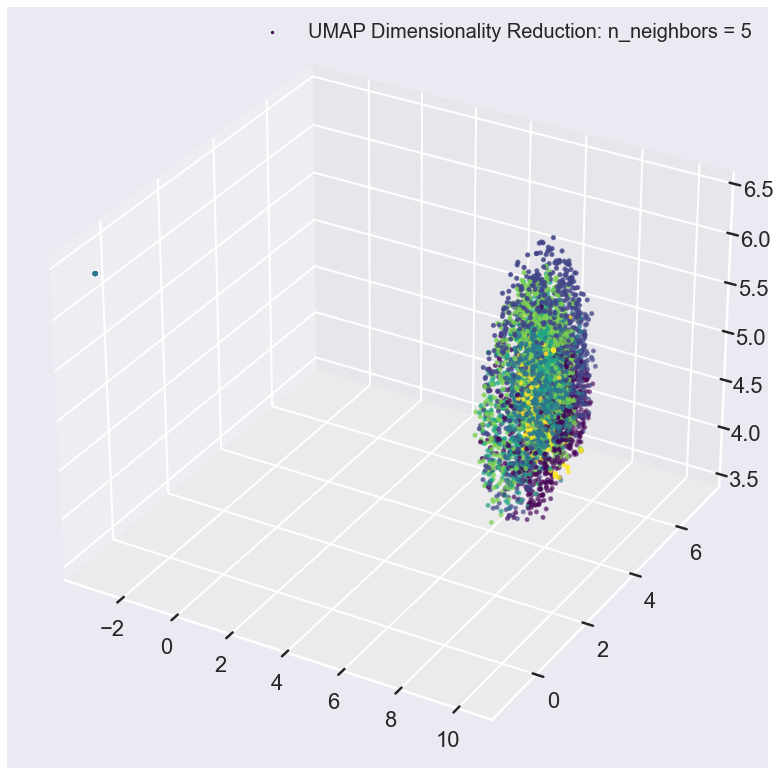

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest           0.75        0.750408     0.751468   
6           K Nearest Neighbor       0.743557        0.744219      0.74464   
3               Decsision Tree       0.617268        0.617527     0.617436   
4                     AdaBoost       0.499356        0.487828     0.497616   
7          Logistic Regression       0.474227        0.471251     0.476052   
5         Gaussian Naive Bayes       0.472938        0.460244     0.476974   
1  Stochastic Gradient Descent       0.362758        0.289542     0.365652   
0                        Dummy       0.154639        0.025773     0.166667   

   f1_score  
2   0.75058  
6  0.743999  
3  0.617246  
4  0.485854  
7  0.460341  
5  0.458007  
1  0.298601  
0  0.044643  


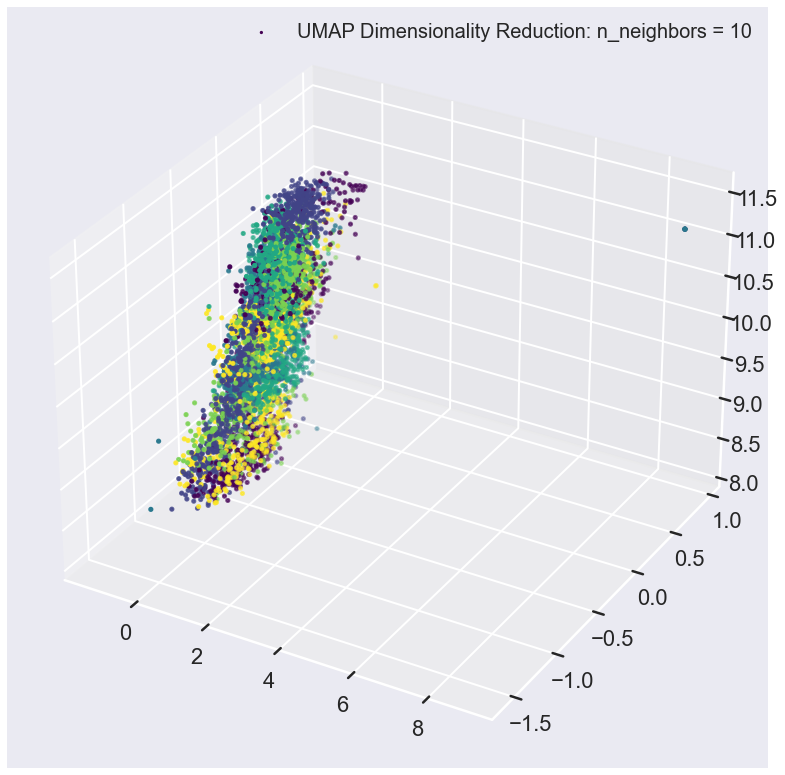

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.907861        0.907495     0.908024   
2                Random Forest       0.903351        0.902627     0.903634   
3               Decsision Tree       0.798969        0.799331     0.798588   
4                     AdaBoost       0.524485        0.519711     0.520889   
5         Gaussian Naive Bayes       0.481959        0.463908     0.476169   
7          Logistic Regression       0.371134        0.371205     0.369583   
1  Stochastic Gradient Descent       0.365979          0.4089     0.367046   
0                        Dummy       0.154639        0.025773     0.166667   

   f1_score  
6  0.907455  
2  0.902878  
3  0.798295  
4  0.510015  
5  0.459274  
7  0.354319  
1  0.303101  
0  0.044643  


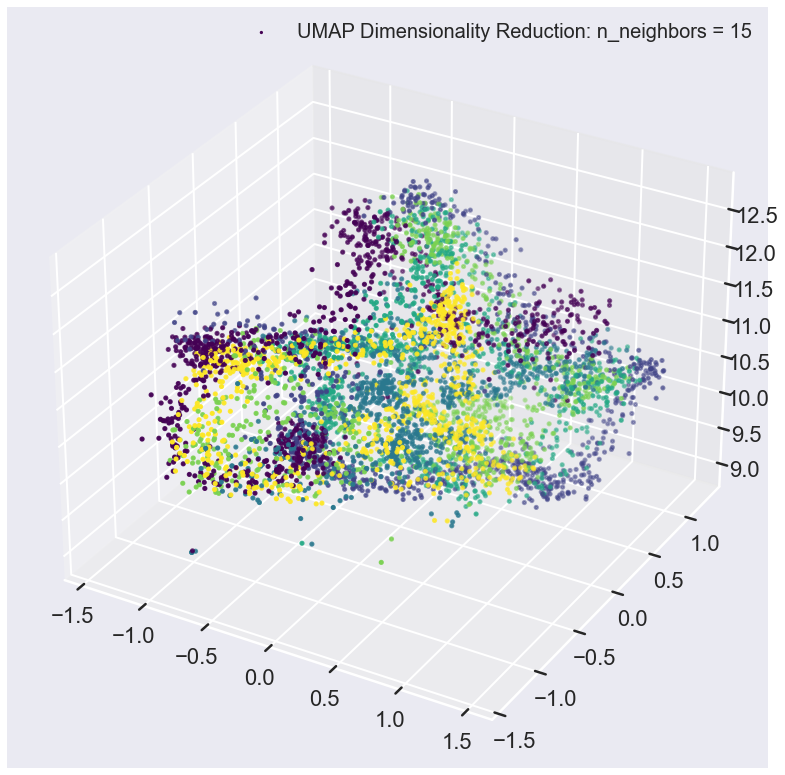

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.888531        0.888153     0.887833   
6           K Nearest Neighbor       0.886598        0.887042     0.885169   
3               Decsision Tree       0.786727        0.784812     0.784566   
4                     AdaBoost       0.450387        0.457174     0.456449   
7          Logistic Regression       0.411727        0.377703     0.405968   
5         Gaussian Naive Bayes       0.409794        0.346618     0.403701   
1  Stochastic Gradient Descent       0.292526        0.473317     0.297173   
0                        Dummy       0.154639        0.025773     0.166667   

   f1_score  
2  0.887474  
6  0.885783  
3  0.784381  
4  0.446465  
7  0.383609  
5  0.362896  
1  0.258297  
0  0.044643  


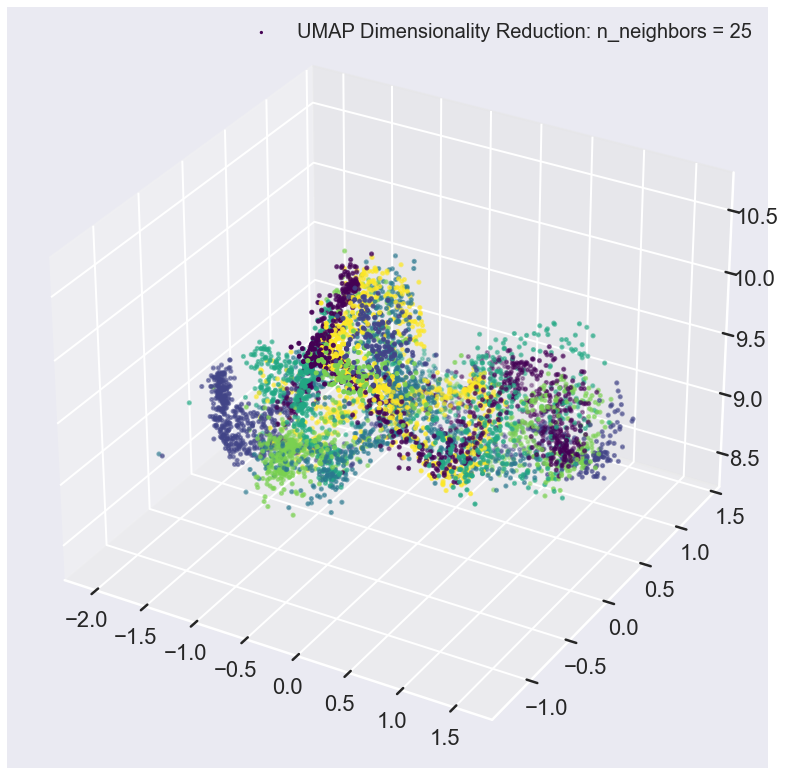

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.953608        0.954169     0.953387   
2                Random Forest         0.9375        0.937179     0.937476   
3               Decsision Tree       0.862758        0.862113     0.862928   
5         Gaussian Naive Bayes        0.39433        0.372579     0.386662   
4                     AdaBoost       0.381443        0.376892      0.38401   
7          Logistic Regression        0.36018        0.354329     0.359338   
1  Stochastic Gradient Descent       0.272552         0.19974     0.265755   
0                        Dummy       0.154639        0.025773     0.166667   

   f1_score  
6  0.953644  
2  0.937222  
3  0.862238  
5  0.371613  
4  0.368429  
7  0.348624  
1  0.170529  
0  0.044643  


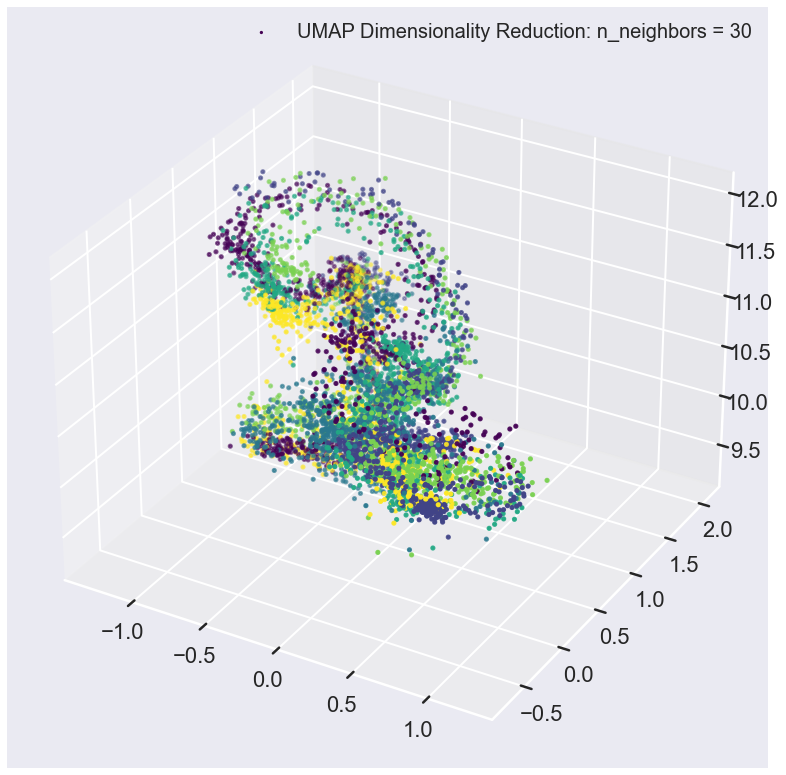

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.926546        0.926833     0.925978   
2                Random Forest        0.88982         0.88858     0.888679   
3               Decsision Tree       0.811856        0.809334     0.809466   
4                     AdaBoost       0.496778        0.494356     0.492316   
5         Gaussian Naive Bayes       0.354381        0.326541     0.347834   
7          Logistic Regression       0.324098        0.309119     0.318901   
1  Stochastic Gradient Descent       0.210052        0.121533     0.220013   
0                        Dummy       0.154639        0.025773     0.166667   

   f1_score  
6   0.92603  
2  0.888534  
3  0.809047  
4    0.4889  
5  0.327546  
7  0.298457  
1  0.122756  
0  0.044643  


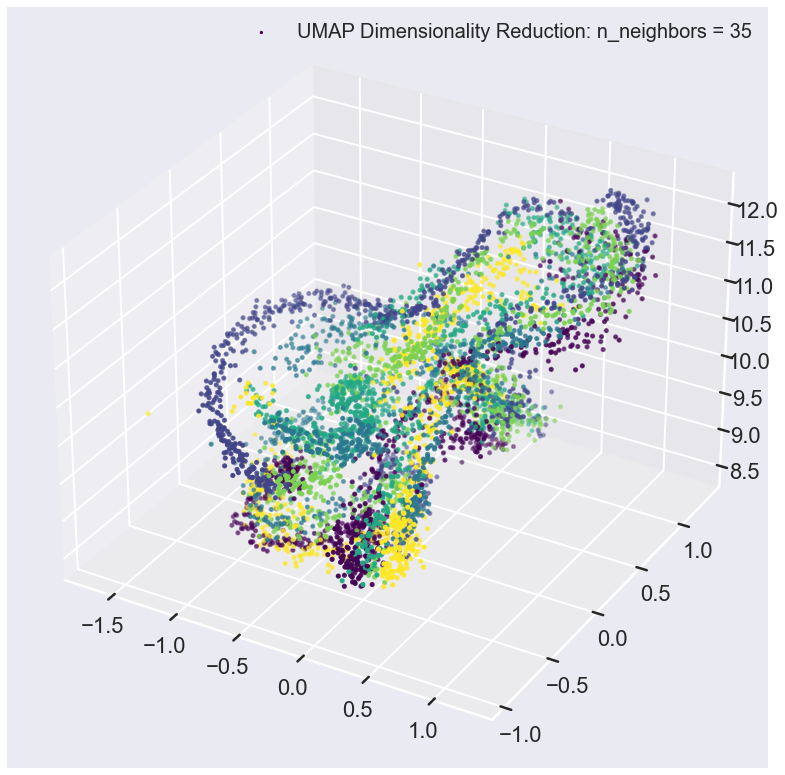

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.936211        0.936415      0.93588   
2                Random Forest       0.923969        0.923678     0.923463   
3               Decsision Tree       0.838918        0.837268     0.837235   
4                     AdaBoost       0.371778         0.42425     0.377069   
5         Gaussian Naive Bayes       0.364691        0.361376     0.360388   
7          Logistic Regression       0.264175        0.244453     0.271288   
1  Stochastic Gradient Descent       0.219072         0.19399     0.225481   
0                        Dummy       0.154639        0.025773     0.166667   

   f1_score  
6  0.935753  
2  0.923263  
3  0.836879  
4  0.372122  
5  0.351598  
7  0.246897  
1   0.11634  
0  0.044643  


In [70]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 6,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res_b)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res_b, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

## Results

The above reached an optimal accuracy at n_neighbors = 25.

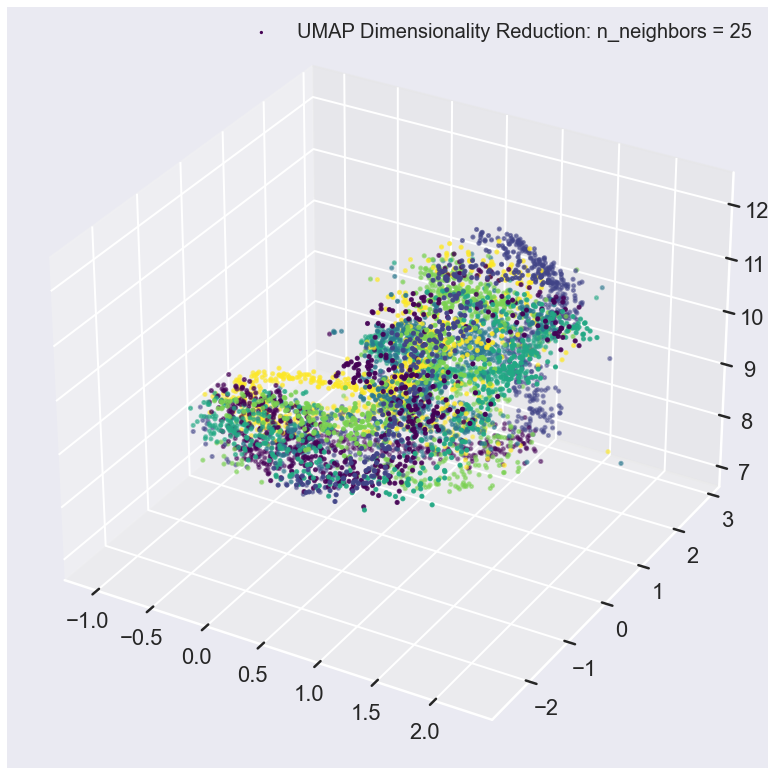

model_name accuracy_score precision_score recall_score  f1_score
3  K Nearest Neighbor       0.864691        0.864468     0.862892  0.863117
0       Random Forest       0.845361        0.844116     0.844114  0.843422
1      Decsision Tree       0.797036        0.794818     0.795504  0.794722
2            AdaBoost       0.375644        0.396638      0.37841   0.37225

In [71]:
fit = umap.UMAP(n_neighbors = 25,
                min_dist = .1,
                n_components = 3,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res_b)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res_b, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 25'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap, 
                                                    y_res_b, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train_b, y_train_b)
        y_pred = v.predict(X_test_b)
        ac_score_list.append(accuracy_score(y_test_b, y_pred))
        p_score_list.append(precision_score(y_test_b, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test_b, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test_b, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res_b, y_res_b)

In [72]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=5,
                                      p =2,
                                      weights='distance')

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


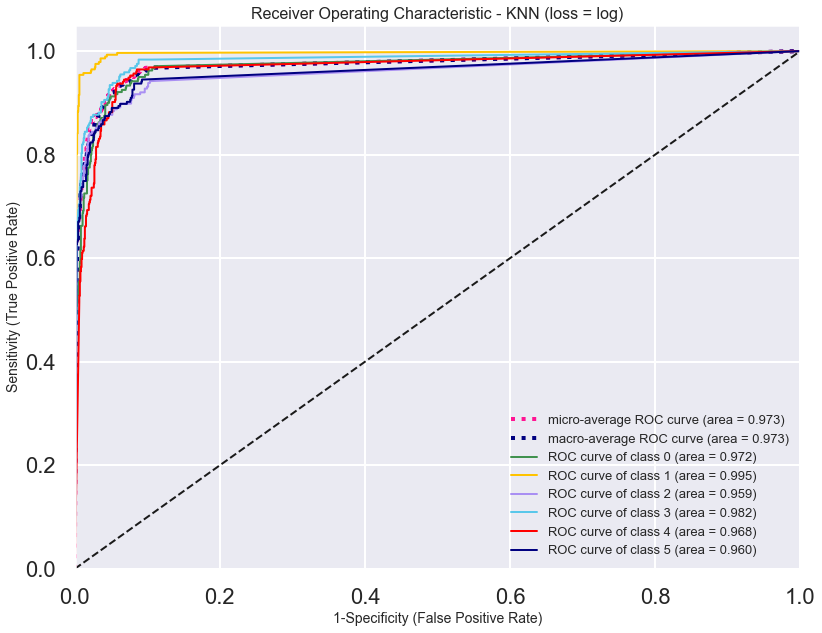

In [73]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res_b, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_c, y_train_c).predict_proba(X_test_c)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_c.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

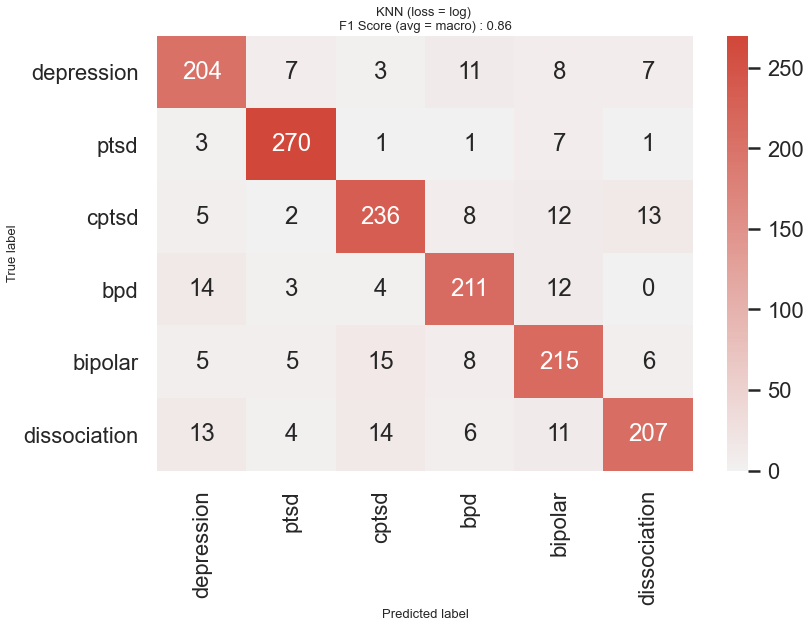

In [74]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_d, y_train_d)
y_pred = knn_best_model.predict(X_test_d)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_d, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_d, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


In [78]:
unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(data_umap,y_res_b)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout

0.2
              precision    recall  f1-score   support

           0       0.20      0.60      0.30         5
           1       0.20      0.60      0.30         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.07      0.20      0.10        30
weighted avg       0.07      0.20      0.10        30



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


text  label  pred_knn  \
0     I feel this way most days and I'm getting sick...      0         0   
1            Saw this today and wanted to share it. 💕 💕      0         1   
2     I can understand if my situation was a permane...      0         0   
3     So suicidal thoughts are really common to me b...      0         1   
4     If any wants to share their experience.\n\nI r...      0         0   
2366  Dave Carbonell, Ph.D, Psychologist, the author...      1         1   
2367  Hi guys,\nI have been diagnosted with a trauma...      1         0   
2368  Sooo, in November 2019, around Thanksgiving, i...      1         0   
2369  My absence record at work is fine. I’ve only h...      1         1   
2370  I was diagnosed with PTSD back in December.\n\...      1         1   
3233  Hi guys! Do anyone stay on high alert so much,...      2         1   
3234  29 year old male.  I have never been diagnosed...      2         0   
3235  Hi, does anyone here have any physical effects...      2         1   
3236  I've been going through a shit ton of trauma l...      2         1   
3237  Hey y'all. I have c-PTSD and a never ending am...      2         1   
4466  Hi, I would really appreciate if anyone could ...      3         0   
4467  Hello, I’ve been googling a lot on this subjec...      3         1   
4468  i had to leave my home and am staying with my ...      3         0   
4469  Hi all I've been recently diagnosed with eupd ...      3         1   
4470  I’ve been feeling so lonely & I don’t have any...      3         0   
6835  Cyclothymia :: Mental Health Issues :: Signpos...      4         1   
6836  Comprehensive information /  FAQ'S about bipol...      4         1   
6837  Hi all I've been recently diagnosed with eupd ...      4         1   
6838  ever feel like you're part of a production?\nb...      4         0   
6839  I find I am looking for the pat on the back ty...      4         0   
9210  I was talking to a coworker an amidst the conv...      5         0   
9211  Hello, I have recently started questioning if ...      5         0   
9212  Hi you lovelies reading. <3 I hope dearly this...      5         0   
9213  Hi,\n\nI'm new here and had multiple dissociat...      5         1   
9214  Sort of the opposite of feeling as if I am not...      5         0   

      correct  
0           0  
1           0  
2           0  
3           0  
4           0  
2366        1  
2367        1  
2368        1  
2369        1  
2370        1  
3233        2  
3234        2  
3235        2  
3236        2  
3237        2  
4466        3  
4467        3  
4468        3  
4469        3  
4470        3  
6835        4  
6836        4  
6837        4  
6838        4  
6839        4  
9210        5  
9211        5  
9212        5  
9213        5  
9214        5